Using device: cuda


c:\Users\haris\anaconda3\envs\CAPSTONE_PROJECT\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Loss: 0.0098
Epoch [2/50], Loss: 0.0095
Epoch [3/50], Loss: 0.0095
Epoch [4/50], Loss: 0.0095
Epoch [5/50], Loss: 0.0095
Epoch [6/50], Loss: 0.0095
Epoch [7/50], Loss: 0.0095
Epoch [8/50], Loss: 0.0095
Epoch [9/50], Loss: 0.0095
Epoch [10/50], Loss: 0.0095
Epoch [11/50], Loss: 0.0095
Epoch [12/50], Loss: 0.0095
Epoch [13/50], Loss: 0.0095
Epoch [14/50], Loss: 0.0095
Epoch [15/50], Loss: 0.0095
Epoch [16/50], Loss: 0.0095
Epoch [17/50], Loss: 0.0095
Epoch [18/50], Loss: 0.0095
Epoch [19/50], Loss: 0.0096
Epoch [20/50], Loss: 0.0095
Epoch [21/50], Loss: 0.0095
Epoch [22/50], Loss: 0.0095
Epoch [23/50], Loss: 0.0095
Epoch [24/50], Loss: 0.0095
Epoch [25/50], Loss: 0.0095
Epoch [26/50], Loss: 0.0095
Epoch [27/50], Loss: 0.0095
Epoch [28/50], Loss: 0.0095
Epoch [29/50], Loss: 0.0095
Epoch [30/50], Loss: 0.0095
Epoch [31/50], Loss: 0.0095
Epoch [32/50], Loss: 0.0095
Epoch [33/50], Loss: 0.0095
Epoch [34/50], Loss: 0.0095
Epoch [35/50], Loss: 0.0095
Epoch [36/50], Loss: 0.0095
E

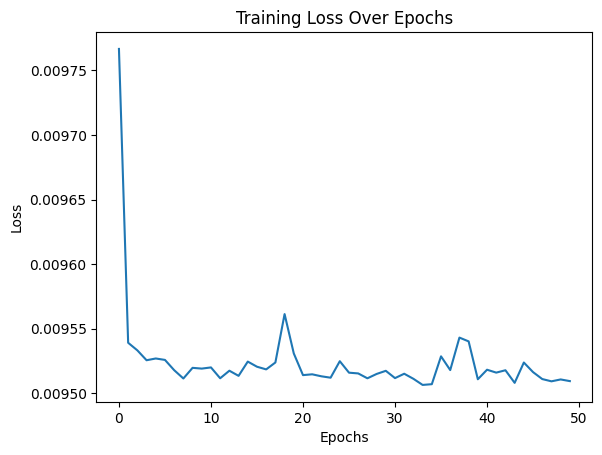

Predictions saved to predicted_trends.csv


In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Data Loading Function ---
def load_data_from_folders(base_directory):
    """
    Recursively loads MAT files from the directory structure.
    """
    all_features, all_targets = [], []
    
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".mat"):
                data_path = os.path.join(root, file)
                mat_data = loadmat(data_path)
                
                # Extract relevant data
                wind_pressure_coefficients = mat_data['Wind_pressure_coefficients']
                mean_pressure_coefficients = wind_pressure_coefficients.mean(axis=1)
                
                # Extract metadata (roof type, height ratio, wind angle)
                roof_pitch = mat_data['Roof_pitch'].flatten()[0]
                building_height = mat_data['Building_height'].flatten()[0]
                wind_azimuth = mat_data['Wind_azimuth'].flatten()[0]
                
                num_samples = len(mean_pressure_coefficients)
                features = np.column_stack((
                    np.full(num_samples, roof_pitch),
                    np.full(num_samples, building_height),
                    np.full(num_samples, wind_azimuth)
                ))
                
                all_features.append(features)
                all_targets.append(mean_pressure_coefficients)
    
    return np.vstack(all_features), np.concatenate(all_targets)

# Set base directory path for data
data_dir = "../data/Low-rise with eaves/roof type a/"
features, targets = load_data_from_folders(data_dir)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# --- Dataset Class ---
class TPUAerodynamicsDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32).to(device)
        self.targets = torch.tensor(targets, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Create dataset and dataloaders
dataset = TPUAerodynamicsDataset(features_scaled, targets)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# --- Neural Network Model ---
class PredictionModel(nn.Module):
    def __init__(self, input_size):
        super(PredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# Initialize model
model = PredictionModel(input_size=features_scaled.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]:.4f}")

# Plot training loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# Predict upcoming trends
model.eval()
predictions = model(torch.tensor(features_scaled, dtype=torch.float32).to(device)).cpu().detach().numpy()

# Save predictions to CSV
output_df = pd.DataFrame(features, columns=["Roof Pitch", "Building Height", "Wind Azimuth"])
output_df["Predicted Mean Pressure Coefficient"] = predictions
output_df.to_csv("predicted_trends.csv", index=False)
print("Predictions saved to predicted_trends.csv")
